<h1 align=center><b>2023 Principle of Data Analytics</b></h1>
<h1 align=center>Analysis of the Palmer Penguins Dataset</h1>
<h3 align=center>Guillermo F. Martin Gonzalez</h3>

**Table of contents**<a id='toc0_'></a>    
- [1. Introduction](#toc1_)    
  - [1.1 Hypothesis](#toc1_1_)    
- [2. Statistical analysis](#toc2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
# Python packages used in the current notebook
import pandas as pd #import pandas library and name it pd
import numpy as np #import numpy library and name it np
import seaborn as sns #import seaborn library and name it sns

# <a id='toc1_'></a>[1. Introduction](#toc0_)

After importing the data into our environment, we firstly visualize and try to understand the variables contained in the .csv file. The dataset contains a total of 7 columns. We can divide the columns in two main categories: 

* <u>Response variables</u>: four different variables related to biological traits, namely bill length (mm; length of the peak), bill depth (mm; depth of the peak), flipper length (mm) and body mass (gr). 
  
* <u>Covariates</u>: three columns which contain information about the sample itself such as the penguin specie (Adelie, Chinstrap, Gentoo), presumably the island (Torgersen,Biscoe, Dream) where the data was taken, the sex (MALE,FEMALE,nan) of the individual. Indivuals were the sex is unkown are categorised as nan.  

In [3]:
# Load the penguins dataset and have a first look at it
df = pd.read_csv("https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv") # Load the data.
#df.head() # Look at the heading of the data
df.info() # Information about each column
#df.sex.unique()
#df.island.unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


Now, a good way of understanding the type of data we have in front and the potential correlations that are present is to do a correlation plot or pair plot. We will use the seaborn package to do so. This type of plot allows to colour the variables plotted based on the level of a different covariate, in this case, we will colour the variables based on the specie.  

The pairplot provides provides a combination of scatter plots and density plots. From the scatter plots, we can see that there is a very clear positive correlation (increse in X with increase in Y) across all the biological traits described previously.The density plots, provides information of how different the biological traits are based on each specie. For instance, we can see that the flipper length and body mass of the Gentoo penguins is larger (density further right) that the other two species, suggesting that the Gentoo penguins are a bigger specie (as confirmed by quickly looking at a height plot from the British Antarctic Survey; Fig. 1). This is not unexpected, as different species would usually display differences in biological traits.  

Now, as we are interested in understanding the potential correlation around biological traits, and given that these traits are quite different across the species in the data, further analysis should really consider the species column as a covariate. Another covariate worth looking at might be the island where the data was taken from or the sex of each individual, as usually, within an specie, biologial traits display different characteristics (sexual dimorphism).  


<figure align=center>
 <img src="https://pbs.twimg.com/media/FJjMJMDX0AcONoE?format=jpg&name=900x900" alt="Alternative text" />
 <figcaption>Figure 1: Height of Antartic penguins. Downloaded <a href="https://twitter.com/BAS_News/status/1484160541069357060">here</a></figcaption>
</figure> 



## <a id='toc1_1_'></a>[1.1 Hypothesis](#toc0_)

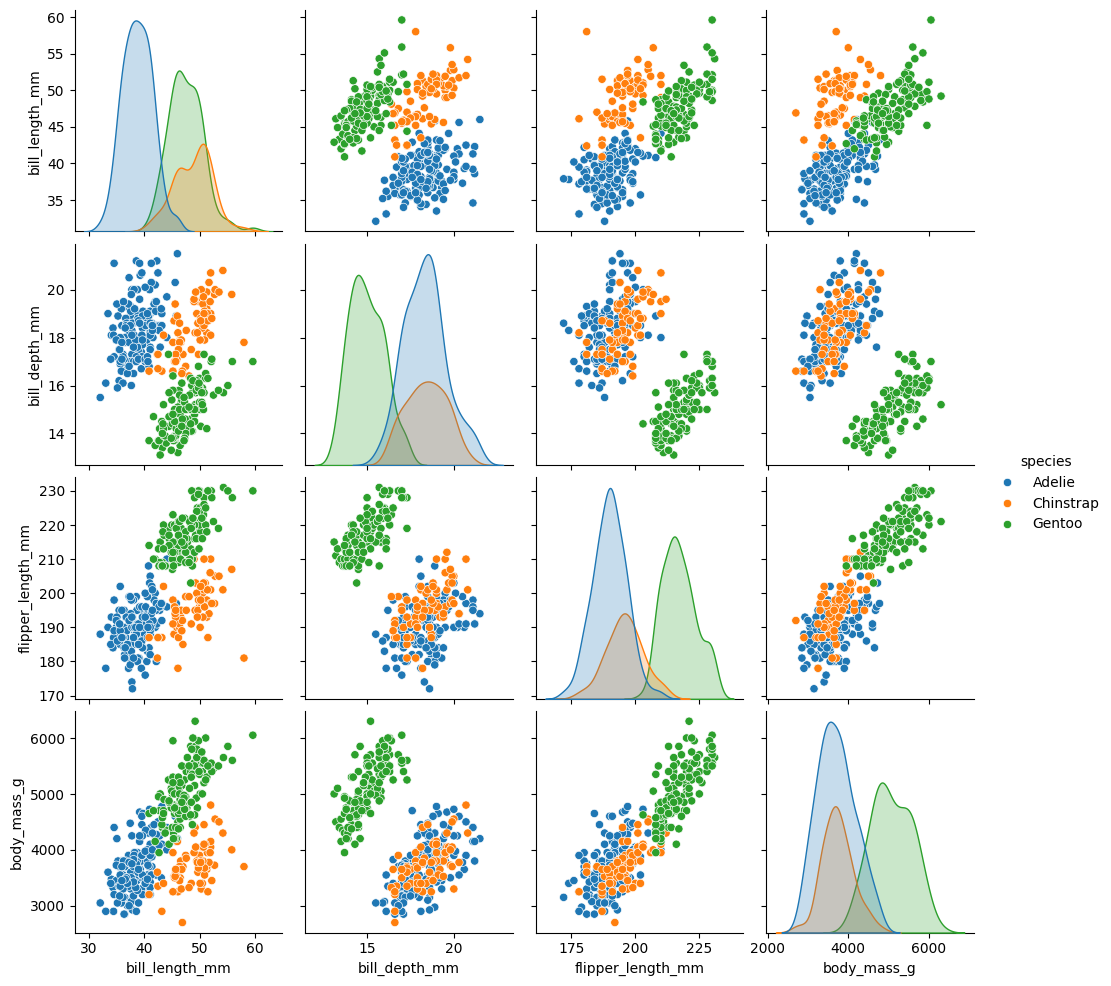

In [3]:
axes = sns.pairplot(df, hue="species")

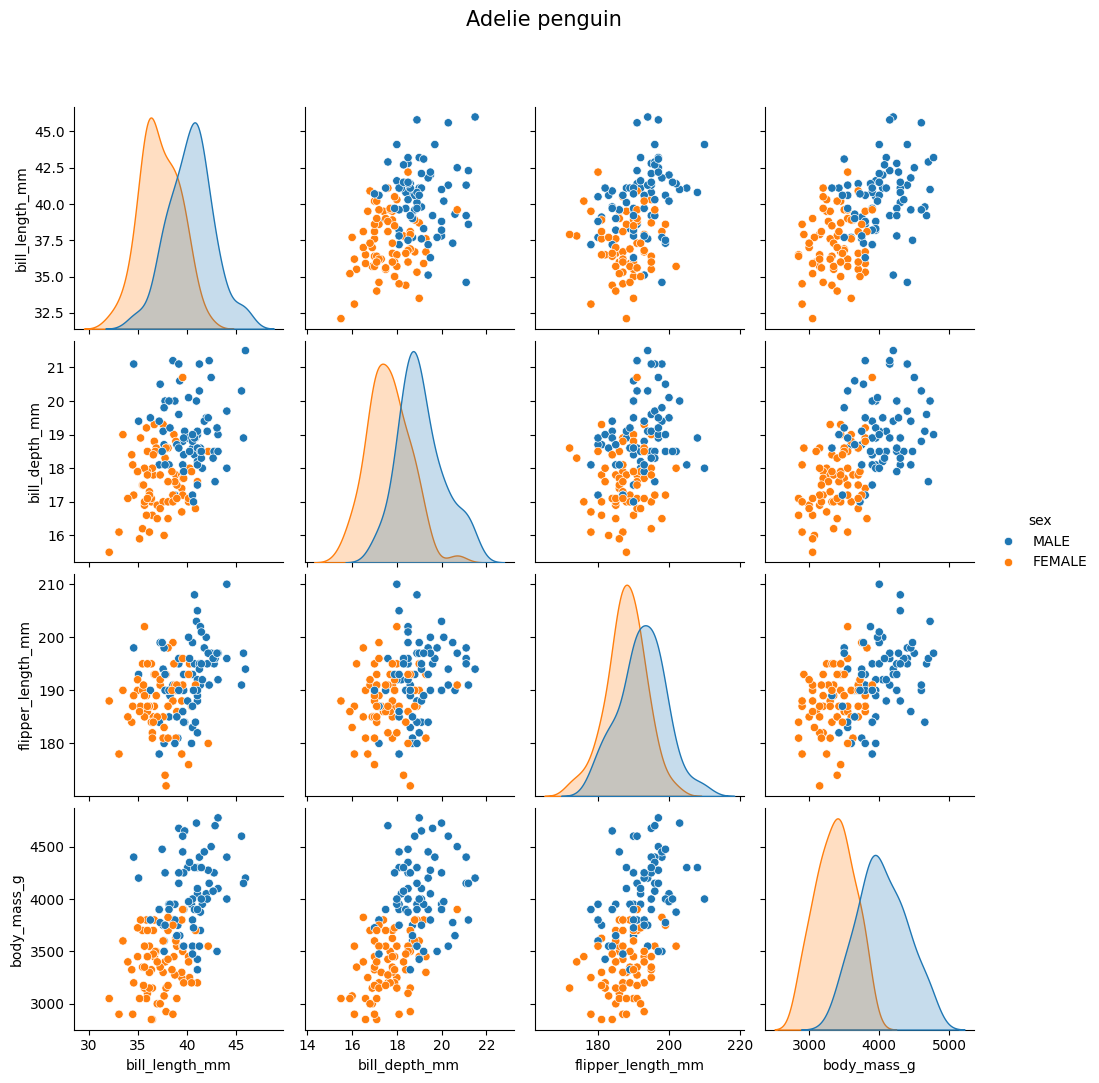

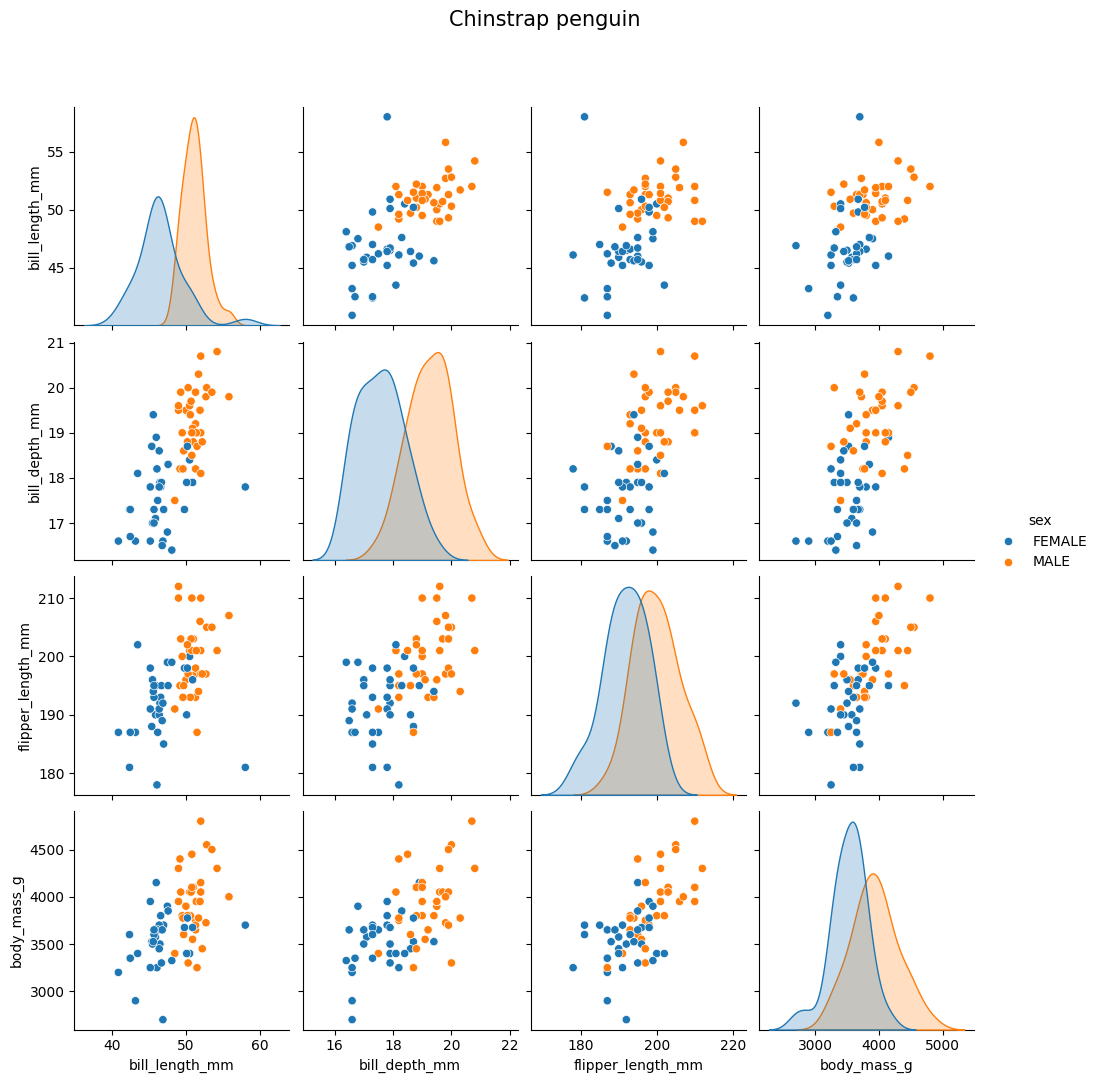

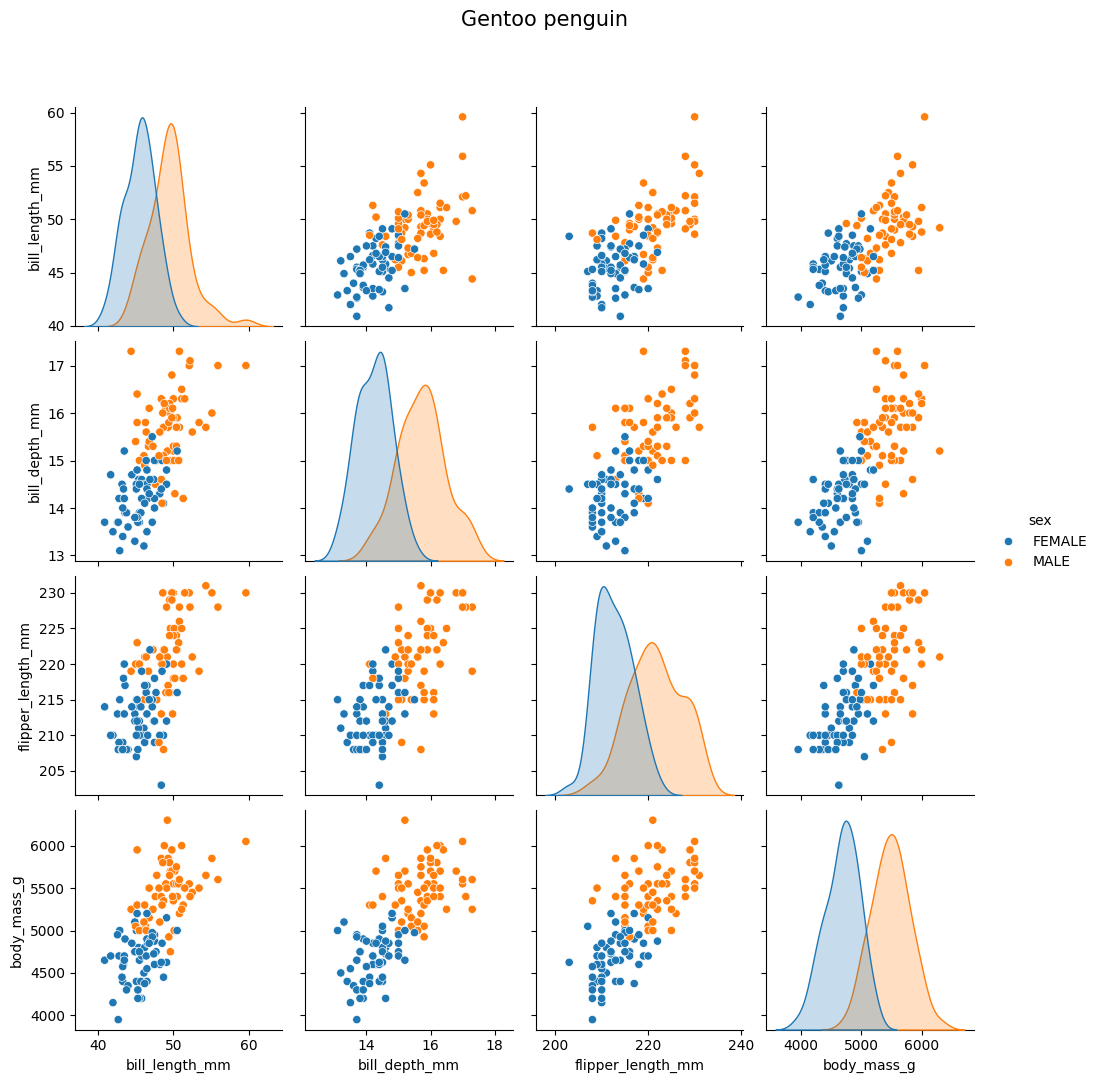

In [4]:
# Making a scatter plot for each specie using the sex as the coloured variable. 
for sp in df.species.unique(): # "for" loop. We will make a plot for each unique value of the species column
    # Create pairplot for the current species group
    p=sns.pairplot(df[df.species == sp], hue="sex") # Making plot for species sp, and colour te variables based on the sex column
    p.fig.suptitle(f"{sp} penguin", y=1.08, fontsize=15) # Create a title for each plot.

# <a id='toc2_'></a>[2. Statistical analysis](#toc0_)

hgewdcfgyhj545fwecd